In [57]:
# This code finds the optimized rise time (k) for the trapizoidal filter. ~20 mins.
# WARNING: produces in inversed graph for some reason. Error not found. 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
from numba import jit
import scipy.optimize as opt
from lmfit.models import GaussianModel, ConstantModel

import tables
import os

In [58]:
m = 24

h5file = tables.open_file("../data/test_input.h5", driver="H5FD_CORE")
print(h5file)
data = h5file.root.RawData
EventData = h5file.root.EventData
print(len(EventData))

data/test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

63734


In [59]:
# Find pulses that triggered multiple times and delete them
i_pileup = 0
j_pileup = 0
pileup_args = np.array([])
EventDataArray = np.array(EventData)

for x in range(len(EventData)):
    if int(EventData[x][3])>1:
        pileup_args = np.append(pileup_args,i_pileup)
        j_pileup = j_pileup+1  
    i_pileup = i_pileup+1

print(data)
print(len(pileup_args))

data = np.delete(data[:], pileup_args, 0)
    
print('deleted ', len(pileup_args),' signals due to pile up')
#print(len(data2))

/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''
1248


/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


deleted  1248  signals due to pile up


In [60]:
@jit(parallel = True)
def baseLineReduction(mysignal):
    avgNoise = np.mean(mysignal[0:1000])
    return mysignal-avgNoise

In [61]:
@jit(parallel = True)
def TrapFilter(mysignal,tau,k,m):
    signalOnly = baseLineReduction(mysignal) 
    M = tau
    Acc1=0.0
    Acc2=0.0
    i=0
    zeros = np.zeros(2*k+m)
    extSignalOnly=np.append(zeros,signalOnly)
    final = np.zeros(len(signalOnly))
    for i in range(len(signalOnly)):
        parta = extSignalOnly[i+(2*k+m)] - extSignalOnly[i-k+(2*k+m)]
        partb = extSignalOnly[i-2*k-m+(2*k+m)] - extSignalOnly[i-k-m+(2*k+m)]
        partc = parta + partb
        Acc1 = Acc1+partc
        partd = partc*M+Acc1
        Acc2 = Acc2 + partd
        final[i] = Acc2
        i=i+1
    
    normFinal = np.array(final)
    return normFinal

In [62]:
rows = len(data[:,0])
print(rows)
cols = len(data[0,:])
mysignals = np.zeros((rows,cols))

@jit(parallel = True)
def makesignals(raw_data):
    for j in range(0,rows):
        mysignals[j] = data[j,:]
    return mysignals

startTime = datetime.now()

mysignals = makesignals(data)

print(datetime.now() - startTime)

62486
0:00:05.312825


In [63]:
@jit(parallel = True)
def func(x, a, b):
    return a * np.exp(-b * x)

In [64]:
@jit(parallel = True)
def eventsProcess(mysignals, events, cols,tau,k,m):
#    tau = np.zeros(events)
    startTime = datetime.now()
    trap_out = np.zeros((events,cols))
    for j in range(0,events):
        trap_out[j] = TrapFilter(mysignals[j,:],tau,k,m)
    print(datetime.now() - startTime)
    return trap_out

In [66]:
@jit(parallel = True)
def gauss(x, a, u, sig):
    return a*np.exp(-(x-u)**2.0/(2.0*sig**2.0))

@jit(parallel = True)
def FWHM(counts,lower_bound,upper_bound):
    X = range(lower_bound, upper_bound)
    Y = counts[lower_bound:upper_bound]
    # Fit a guassian
    mean = sum(X * Y) / sum(Y)
    sigma = np.sqrt(sum(Y * (X - mean)**2) / sum(Y))
#    pi = [max(Y),mean,sigma]
#    popt, pcov = curve_fit(gauss, X, Y, p0=pi)
#    print(popt)
#    fit_a, fit_mu, fit_stdev = popt
    # fit guassian using other method
    model = GaussianModel(prefix='peak_') + ConstantModel()
    # make a model that is a Gaussian + a constant:
    model = GaussianModel(prefix='peak_') + ConstantModel()

    # make parameters with starting values:
    params = model.make_params(c=1.0, peak_center=mean, peak_sigma=sigma, peak_amplitude=max(Y))
    # run fit
    result = model.fit(Y, params, x=X)
    print('fwhm: ', result.params['peak_fwhm'].value, 'centroid: ', result.params['peak_center'].value)
    # find FWHM
#    fwhm = 2*np.sqrt(2*np.log(2))*np.abs(fit_stdev)
#    cent = fit_mu
    return result.params['peak_fwhm'].value, result.params['peak_center'].value

In [67]:
@jit(parallel = True)
def TraptoCounts(trap_out,k,M):
    counts = []
    for j in range(0,len(trap_out)):
        counts = np.append(counts,np.amax(trap_out[j]))
    counts2 = np.trim_zeros(counts)
    counts2 = counts2/((M+1)*k)
    counts3 = counts2[(counts2>0) & (counts2<1e3)]
    yhist, bins_hist = np.histogram(counts3,bins=8196)
    return yhist

# convert Traps to Counts and then do FWHM on the Peak
#plt.figure()
#nhist, bins, ign = plt.hist(counts3,bins=8196)

In [68]:
print(len(mysignals))
events = len(mysignals)
tau = 5810.79
@jit(parallel = True)
def find_k(mysignals, events, cols, tau, m):
    out_f = []
    out_c = []
    for k in range(200,1200,20):
        processedEvents = eventsProcess(mysignals,events,cols,tau,k,m)
        counts = TraptoCounts(processedEvents,k,tau)
        out_fwhm, out_cent = FWHM(counts,6000,6500)
        out_f.append(out_fwhm)
        out_c.append(out_cent)
        print('k=',k)
    return out_f, out_c

startTime = datetime.now()
#find k first
FWHM_k, cent_k = find_k(mysignals,events,cols,tau,m)

print(datetime.now() - startTime)

62486
0:00:22.145774
fwhm:  22.995295099984617 centroid:  6174.04954207852
k= 200
0:00:21.973356
fwhm:  22.45980147744489 centroid:  6173.471922521028
k= 220
0:00:16.663330
fwhm:  22.100439376399486 centroid:  6173.902048982623
k= 240
0:00:15.478251
fwhm:  21.868787554804232 centroid:  6173.879183128039
k= 260
0:00:15.816603
fwhm:  21.672201654949546 centroid:  6174.342139773912
k= 280
0:00:14.180267
fwhm:  21.674934268877884 centroid:  6174.6386233082
k= 300
0:00:17.982575
fwhm:  21.754811887521186 centroid:  6175.488802760299
k= 320
0:00:14.156706
fwhm:  22.056687865452282 centroid:  6174.808166152958
k= 340
0:00:11.669751
fwhm:  22.37184668582871 centroid:  6175.080927117851
k= 360
0:00:11.181179
fwhm:  22.64943172723405 centroid:  6167.512919550791
k= 380
0:00:10.651173
fwhm:  23.208682227419747 centroid:  6175.012721838265
k= 400
0:00:10.647241
fwhm:  23.37586165130524 centroid:  6175.258909195172
k= 420
0:00:10.572660
fwhm:  23.60655744826383 centroid:  6174.76938888511
k= 440
0:

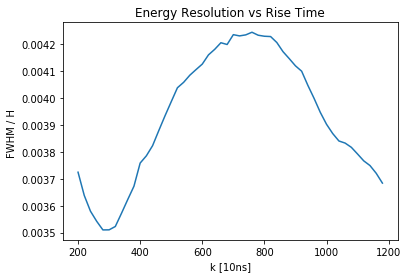

In [69]:
plt.figure()
fwhm_1 = np.array(FWHM_k)
h = np.array(cent_k)
fwhm_f = fwhm_1/h
plt.plot(range(200,1200,20),fwhm_f)
plt.xlabel('k [10ns]')
plt.ylabel('FWHM / H ')
plt.title('Energy Resolution vs Rise Time')
plt.savefig('../images/RvsK.png')